## GPU output buffers

The output image buffer, as well as several other buffers with the image info, are exposed for a zero-copy access. This can be useful e.g. for implementation of a custom postprocessing algorithm.

Buffers should be accessed in callbacks, otherwise content may change or the memory may be released e.g. when the output is resized.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import TkOptiX
from plotoptix.enums import DenoiserKind

Setup the raytracer using Tkinter GUI as the output target:

In [2]:
def image_ready(rt: TkOptiX) -> None: print("ready!")

rt = TkOptiX(on_rt_accum_done=image_ready, start_now=False)

rt.set_param(min_accumulation_step=1,
             max_accumulation_frames=4,
             # use these parameters to keep albedo/normals available when denoiser is disabled
             #save_albedo=True,
             #save_normals=True
            )

rt.set_background(0)
rt.set_ambient([0.01, 0.1, 0.25])

rt.setup_camera("cam1", eye=[20, 40, 100], target=[0, 0, 0], fov=23, glock=True)
rt.setup_area_light("light1", center=[80, 40, 80], target=[0, 0, 0], u=20, v=30, color=[23, 21, 17])

# setup denoiser to enable albedo and normal buffers
rt.set_float("tonemap_exposure", 1.1)
rt.set_float("tonemap_gamma", 2.2)
rt.set_float("denoiser_blend", 0.25)
rt.set_int("denoiser_kind", DenoiserKind.RgbAlbedoNormal.value)
rt.add_postproc("Denoiser")

Load mesh from a file:

In [3]:
rt.load_mesh_obj("data/utah-teapot.obj", c=0.92, make_normals="True")

Start the GUI window and wait for the "ready!" message, telling all the ray-tracing is completed. We'll start with reading buffers directly, with no callbacks, for simplicity. Callback is configured later on.

In [4]:
rt.start()

ready!


GUI window is showing 8-bit/channel image clamped to the 0-255 color values (available in `rt._img_rgba` buffer). But there is also the raw 32-bit/channel floating point version of that image in `rt._raw_rgba`.

<IPython.core.display.Javascript object>


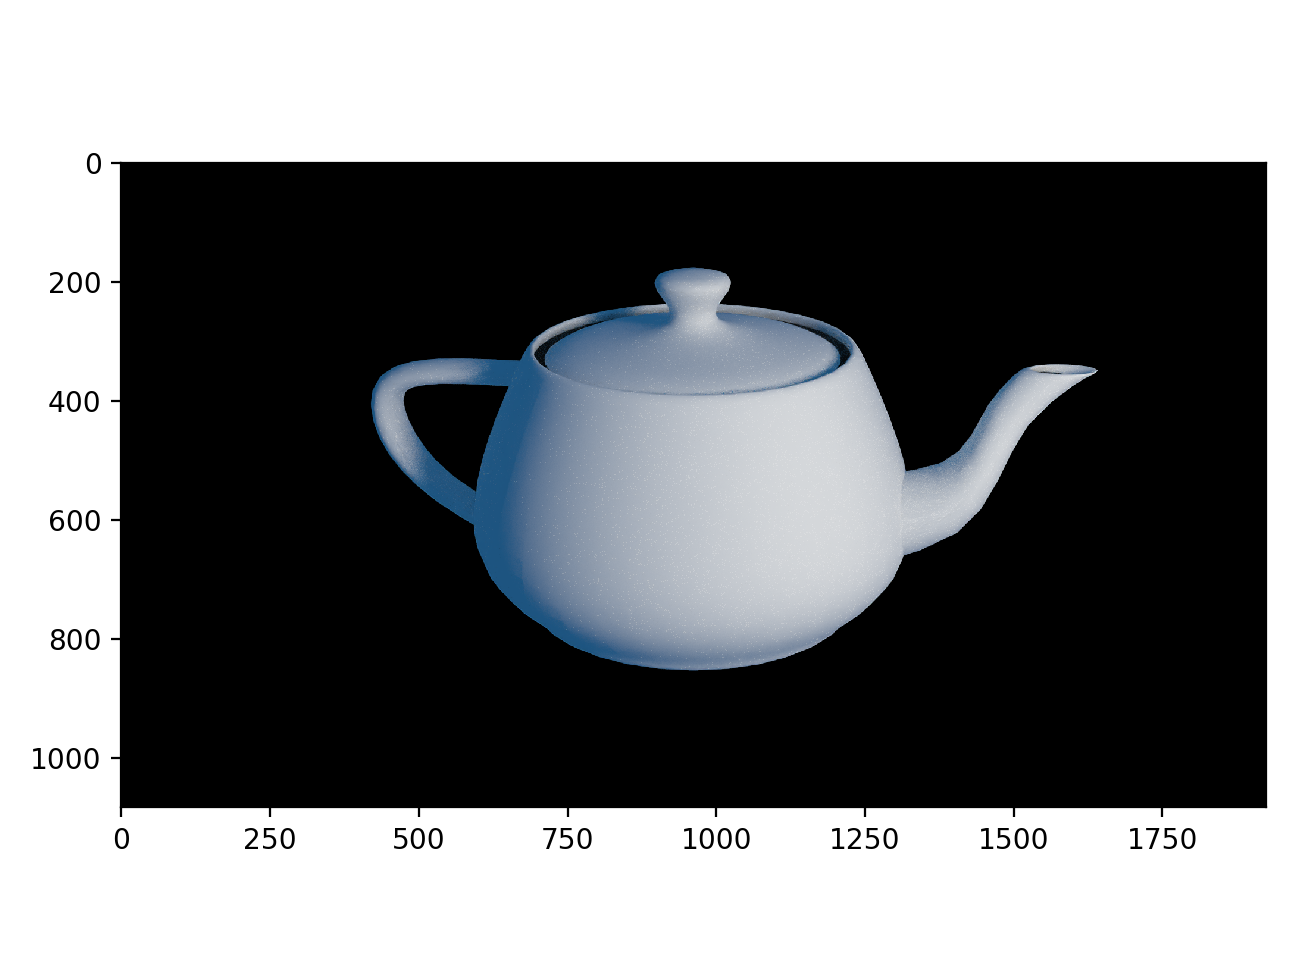

Max color value in the raw image: 1.0617948


In [5]:
plt.figure(1)
raw = plt.imshow((1/np.amax(rt._raw_rgba[:,:,:3])) * rt._raw_rgba[:,:,:3]) # skip alpha in scaling (constant 1.0)
print("Max color value in the raw image:", np.amax(rt._raw_rgba[:,:,:3]))
plt.tight_layout()

Hit info for each pixel is stored in `rt._hit_pos` buffer. First three values are the 3D hit coordinates, the 4-th value is the hit distance to the camera plane, displayed below:

<IPython.core.display.Javascript object>


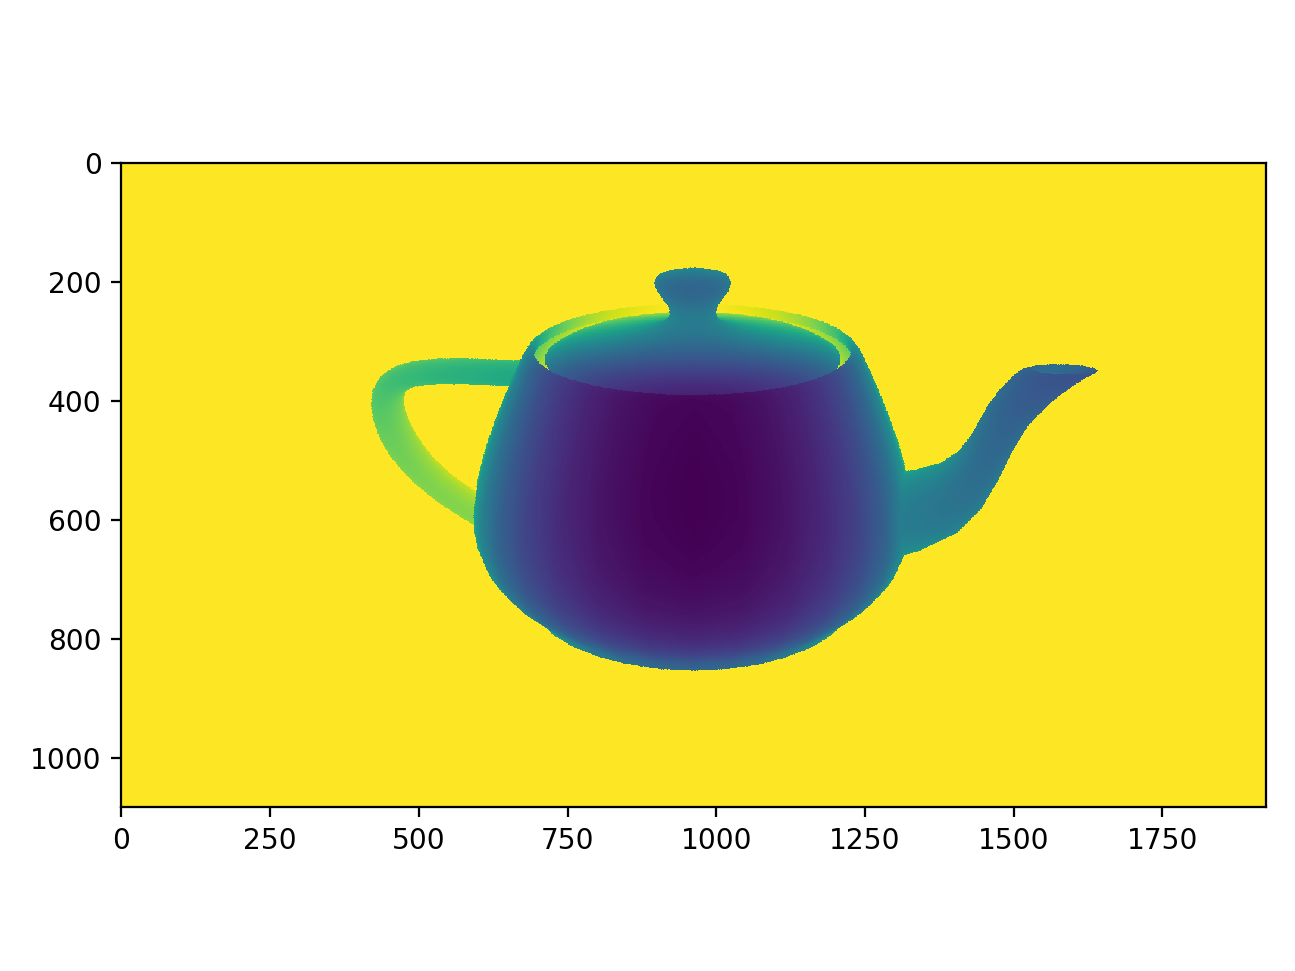

Distance range: 95.32462 115.86612


In [6]:
plt.figure(2)
d = rt._hit_pos[:,:,3].reshape(rt._height, rt._width) # make 2D array from the hit distance values
d0 = np.amin(d)
d1 = np.amax(d[d<1000]) # skip background pixels, where the distance to the camera plane is a very large value 
dist = plt.imshow(d, vmin=d0, vmax=d1)
plt.tight_layout()
print("Distance range:", d0, d1)

Geometry info is stored in `rt._geo_id` buffer. There are two np.uint32 values encoding the mesh or data set handle, the face or primitive index and the vertex id in case of meshes. The object handle and vertex id (if present) are encoded in the fist value as `(vtx_id << 30) | handle`; `vtx_id` is the index of the triangular face vertex closest to the hit, values are 0, 1 or 2. Background areas are tagged with `0xFFFFFFFF` value in both fields.

<IPython.core.display.Javascript object>


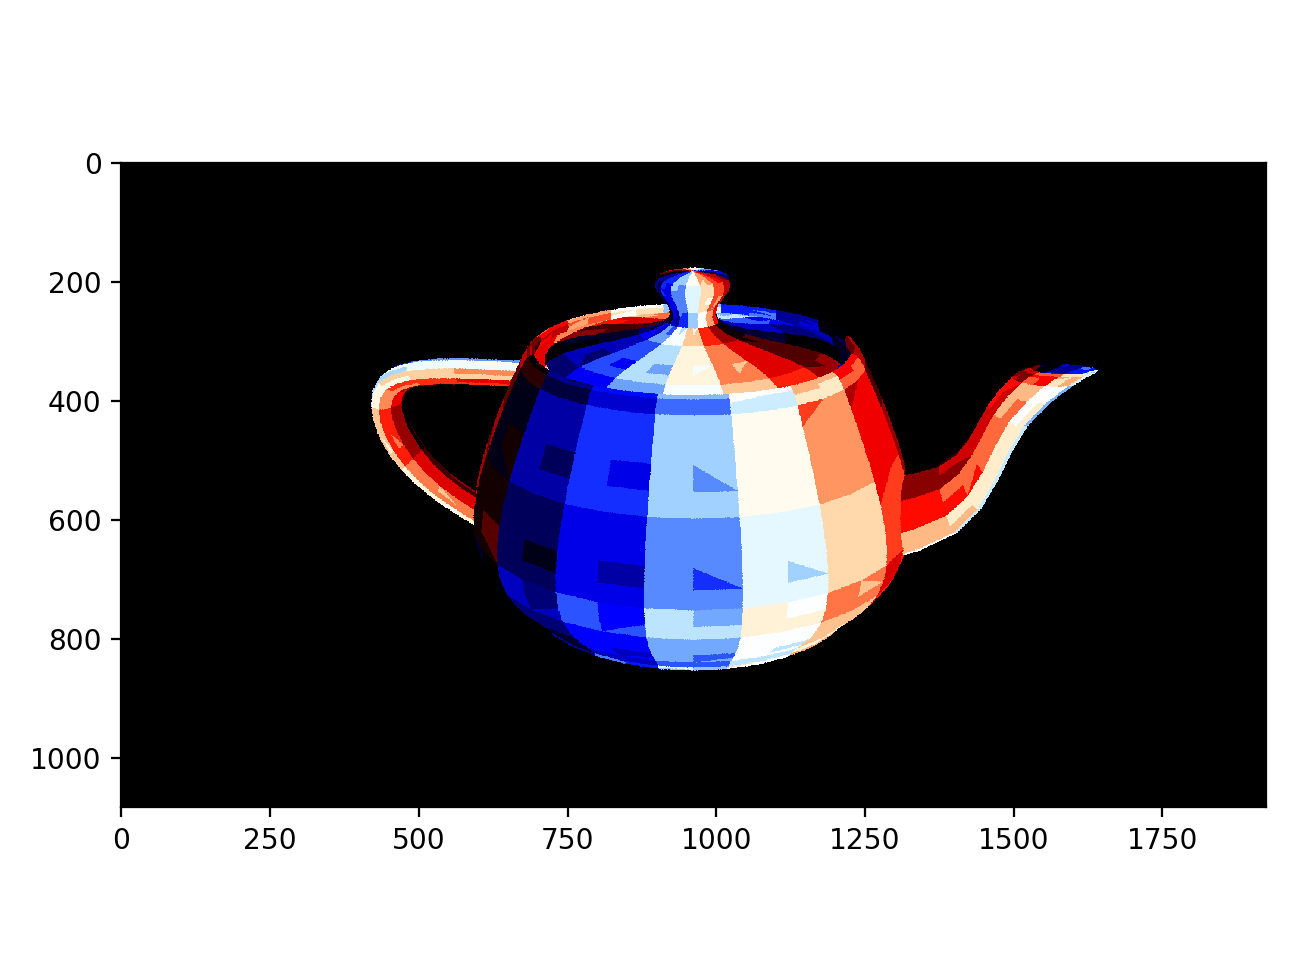

In [7]:
plt.figure(3)
f = rt._geo_id[:,:,1].reshape(rt._height, rt._width) # select face index values
f1 = np.amax(f[f < 0xFFFFFFFF]) # skip background
f0 = np.amin(f)
faces = plt.imshow(f, vmin=f0, vmax=f1, cmap=plt.get_cmap("flag"))
plt.tight_layout()

Albedo (surface color) and normal vectors (in camera space) are available only if denoiser is enabled in postprocessing and configured to `DenoiserKind.RgbAlbedoNormal` or `DenoiserKind.RgbAlbedo` (enables albedo buffer only) mode, or when `save_albedo` and/or `save_normal` parameters are set to `True`. When not available, `rt._albedo` and `rt._normals` are `None` values.

<IPython.core.display.Javascript object>


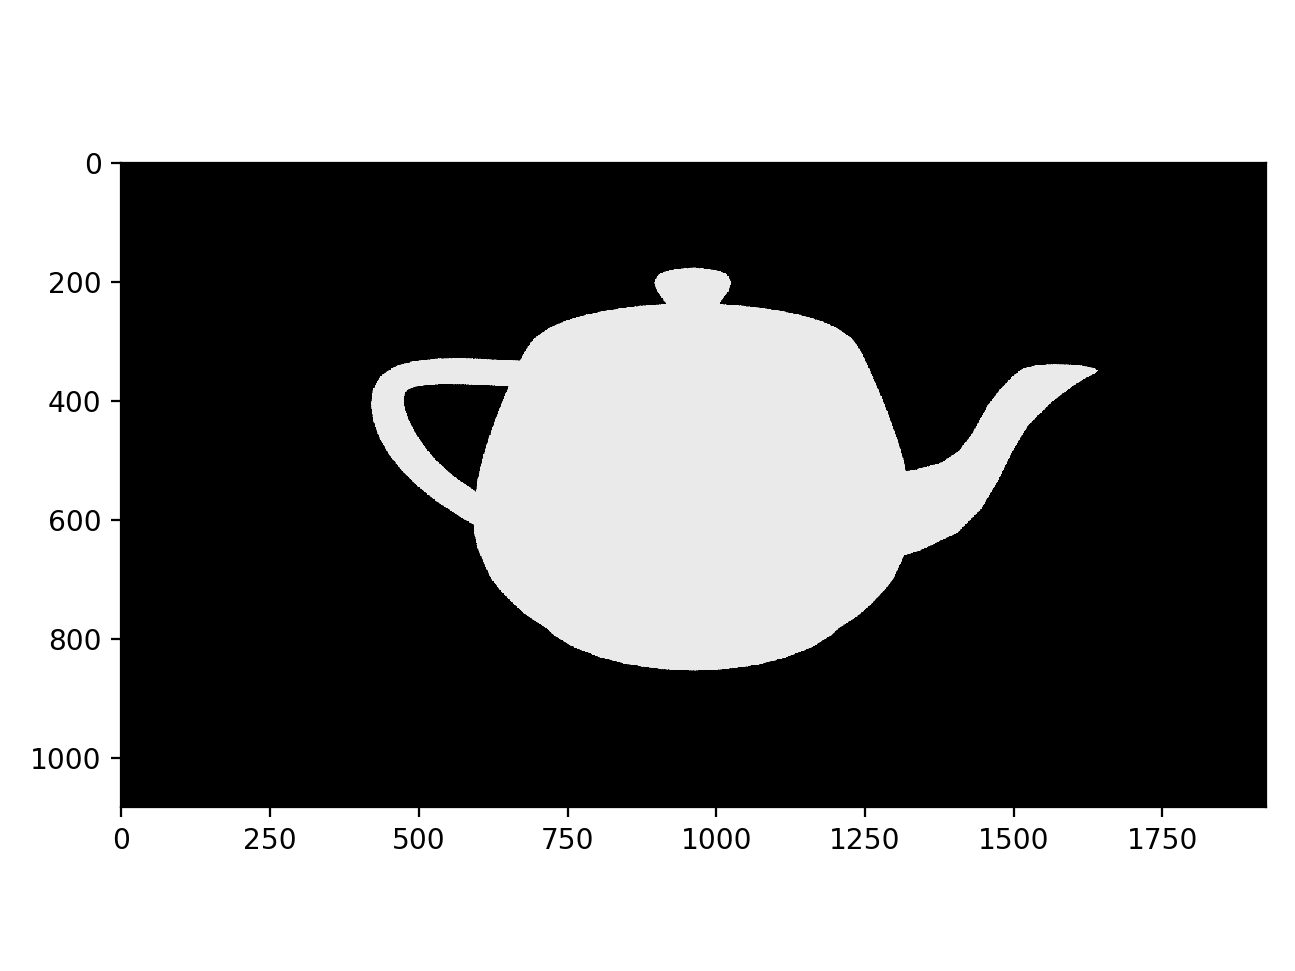

In [8]:
plt.figure(4)
albedo = plt.imshow(rt._albedo[:,:,:3]) # skip the 4-th value (now constant, 0.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


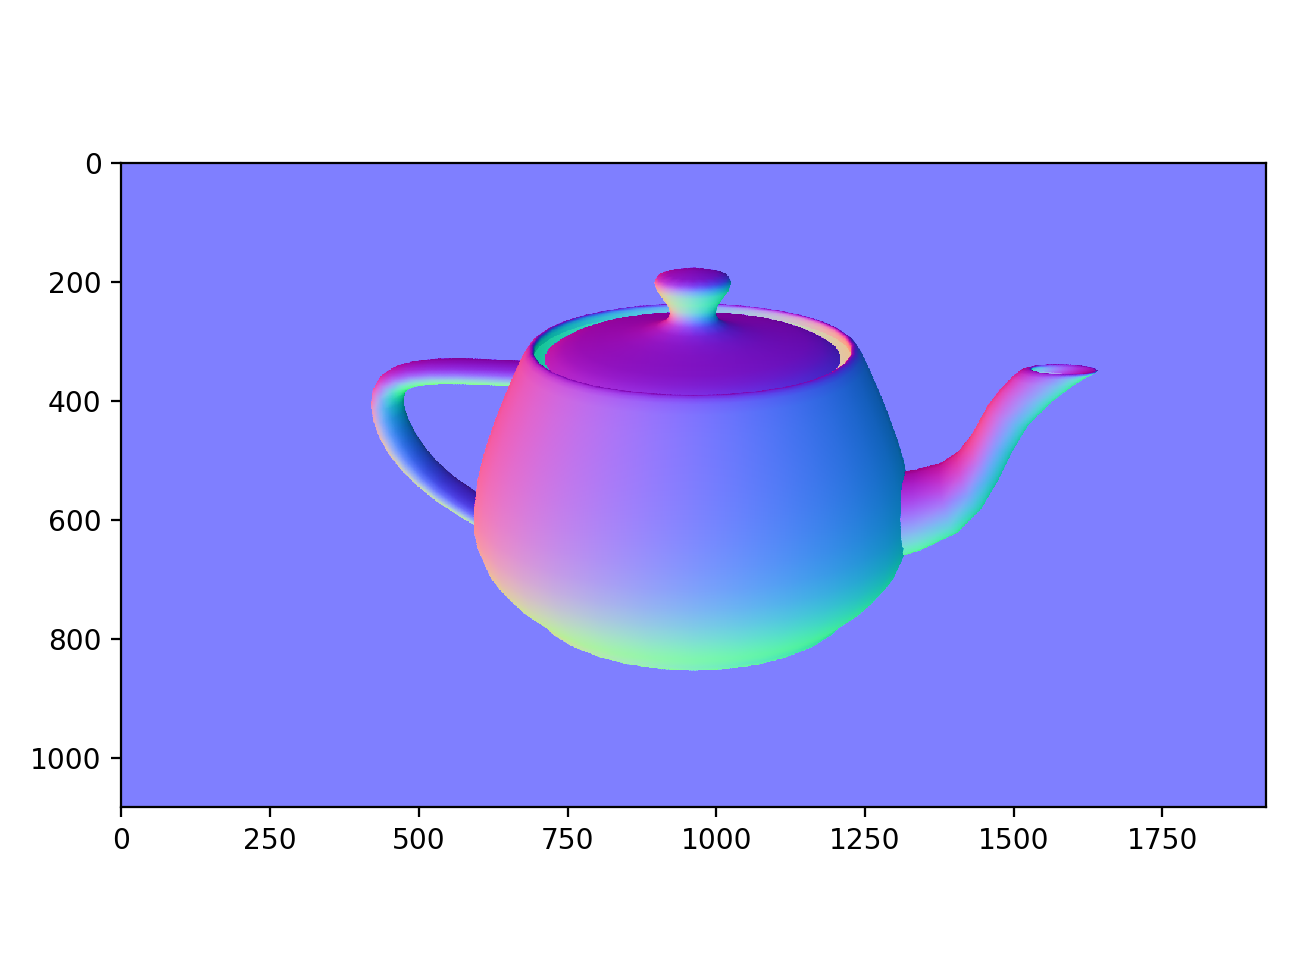

In [9]:
plt.figure(5)
normals = plt.imshow(0.5 * (rt._normal[:,:,:3] + 1)) # skip the 4-th value and map xyz to <0; 1> range
plt.tight_layout()

Callbacks are the safe way of reading buffers, ensuring that the buffer content is stable and that underlaying memory wont disappear when the output is resized. Setup callback with the code below and try rotating camera in the GUI window.

In [10]:
def image_ready(rt: TkOptiX) -> None:
    h = rt._img_rgba.shape[0]
    w = rt._img_rgba.shape[1]
    
    raw.set_data((1/np.amax(rt._raw_rgba[:,:,:3])) * rt._raw_rgba[:,:,:3])
    
    d = rt._hit_pos[:,:,3].reshape(h, w)
    d0 = np.amin(d)
    d1 = np.amax(d[d<1000])
    dist.set_data(d)
    dist.set_clim(vmin=d0, vmax=d1)
    
    f = rt._geo_id[:,:,1].reshape(h, w)
    f1 = np.amax(f[f < 0xFFFFFFFF])
    f0 = np.amin(f)
    faces.set_data(f)
    faces.set_clim(vmin=f0, vmax=f1)

    albedo.set_data(rt._albedo[:,:,:3])
    normals.set_data(0.5 * (rt._normal[:,:,:3] + 1))
    
    plt.draw()
    
# update figures on each accumulation frame:
rt.set_launch_finished_cb(image_ready)

# or update figures when accumulation is finished:
#rt.set_accum_done_cb(image_ready)

Close the ray-tracer.

In [11]:
rt.close()